In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PIPELINE DE CLUSTERING - COURBES DE CHARGE ÉLECTRIQUE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

[Étape 1.1] Chargement des données brutes...
Fichier : /content/drive/MyDrive/export.csv

[Diagnostic] Vérification après chargement...
  Colonnes : ['id', 'horodate', 'valeur']
  Shape : (8736000, 3)
  Type de 'horodate' : object
  Type de 'id' : object
  Type de 'valeur' : float32

✓ Données chargées : 8,736,000 lignes | 500 PDL uniques
✓ Période : 2023-11-01T00:00:00+01:00 → 2024-10-29T23:30:00+01:00
✓ Mémoire utilisée : 1157.20 MB

[Étape 2.1] Création des colonnes temporelles...
Type actuel de 'horodate' : object
Premiers exemples :
0    2023-11-01T00:00:00+01:00
1    2023-11-01T00:30:00+01:00
2    2023-11-01T01:00:00+01:00
Name: horodate, dtype: object

[Conversion] Conversion en datetime avec gestion fuseau horaire...
  Méthode : pd.to_datetime(utc=True) pour forcer datetime64[ns]
✓ Conversion UTC 

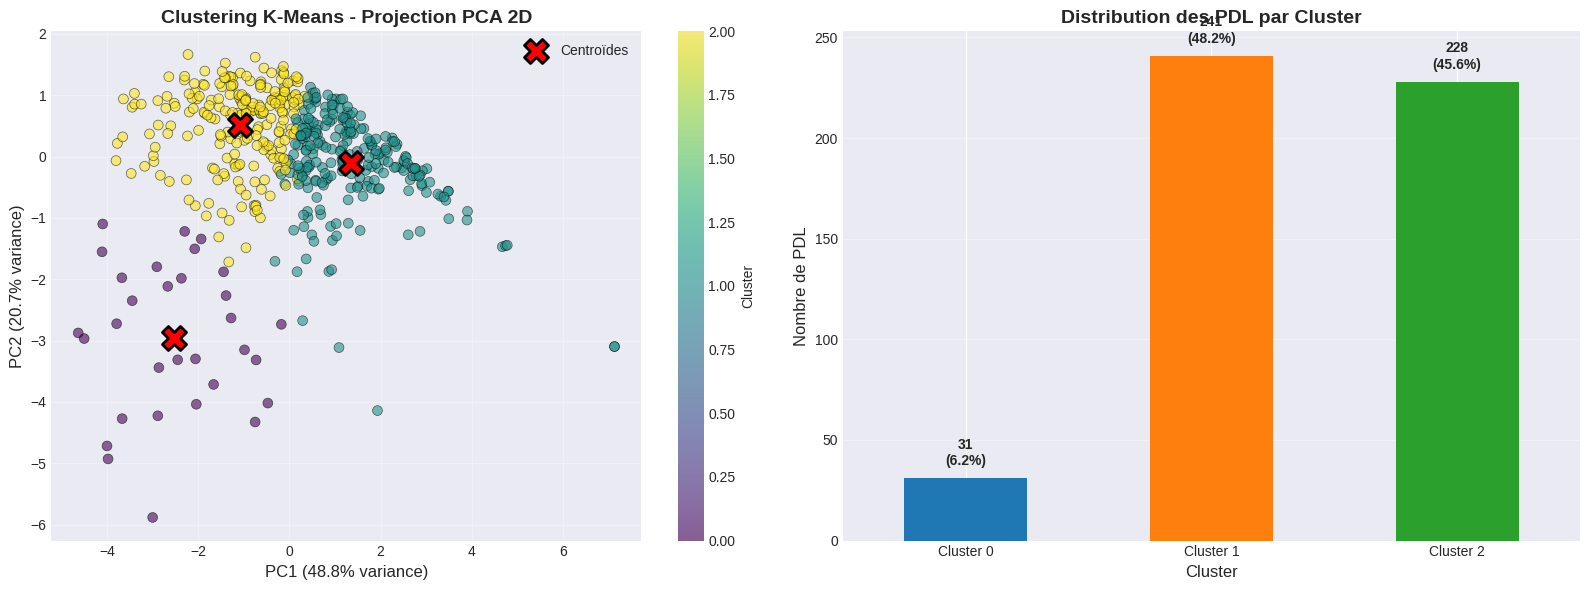


[Étape 9.2] Heatmap des caractéristiques moyennes par cluster...
✓ Heatmap sauvegardée : clustering_heatmap.png


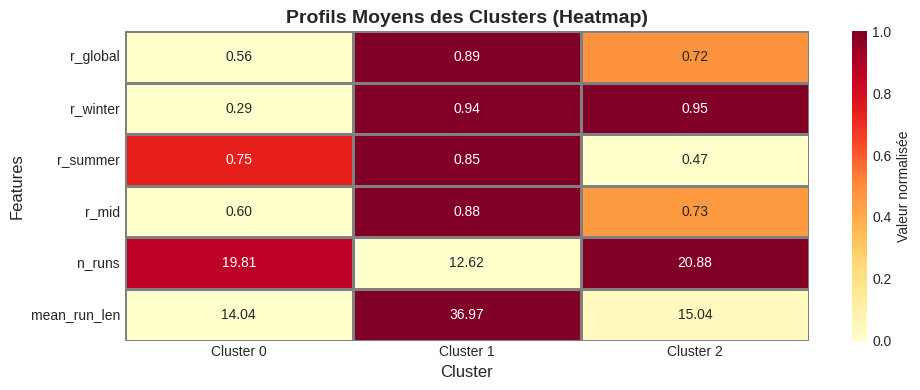


[Étape 10] Export des résultats...
✓ Résultats exportés : /content/drive/MyDrive/resultats_clustering.csv
✓ Colonnes exportées : ['id', 'cluster', 'r_global', 'r_winter', 'r_summer', 'r_mid', 'n_runs', 'mean_run_len']

✅ PIPELINE TERMINÉ AVEC SUCCÈS
📊 500 PDL clusterisés en 3 groupes
📁 Fichiers générés :
   - resultats_clustering.csv
   - clustering_results.png
   - clustering_heatmap.png


In [ ]:
"""
=============================================================================
CLUSTERING DE COURBES DE CHARGE ÉLECTRIQUE
Méthodologie : Deep Learning appliqué à l'énergie
=============================================================================

Pipeline complet : données brutes → preprocessing → features → clustering

Auteur : Data Scientist Expert Énergie
Environnement : Google Colab
Optimisations : Opérations vectorisées, gestion mémoire efficace
"""

# =============================================================================
# SECTION 1 : IMPORTS ET CONFIGURATION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Configuration pour l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("PIPELINE DE CLUSTERING - COURBES DE CHARGE ÉLECTRIQUE")
print("=" * 80)

# =============================================================================
# SECTION 2 : MONTAGE GOOGLE DRIVE ET IMPORT DONNÉES
# =============================================================================

# Montage de Google Drive
drive.mount('/content/drive')

# Configuration du chemin vers votre fichier CSV
# ⚠️ MODIFIER CE CHEMIN SELON VOTRE ARBORESCENCE GOOGLE DRIVE
CHEMIN_CSV = '/content/drive/MyDrive/export.csv'

print("\n[Étape 1.1] Chargement des données brutes...")
print(f"Fichier : {CHEMIN_CSV}")

# Chargement optimisé avec types définis (économie mémoire)
# Note : on ne parse PAS les dates ici, on les convertira manuellement ensuite
df_raw = pd.read_csv(
    CHEMIN_CSV,
    dtype={
        'id': 'str',
        'valeur': 'float32'  # float32 au lieu de float64 pour économiser la mémoire
    }
    # IMPORTANT : pas de parse_dates pour gérer manuellement les fuseaux horaires
)

# Diagnostic immédiat du chargement
print(f"\n[Diagnostic] Vérification après chargement...")
print(f"  Colonnes : {df_raw.columns.tolist()}")
print(f"  Shape : {df_raw.shape}")
print(f"  Type de 'horodate' : {df_raw['horodate'].dtype}")
print(f"  Type de 'id' : {df_raw['id'].dtype}")
print(f"  Type de 'valeur' : {df_raw['valeur'].dtype}")

# Vérification que horodate est bien en string/object
if df_raw['horodate'].dtype != 'object':
    print(f"\n⚠️ ATTENTION : 'horodate' a été auto-parsé en {df_raw['horodate'].dtype}")
    print(f"  Ceci peut causer des problèmes avec les fuseaux horaires")

print(f"\n✓ Données chargées : {len(df_raw):,} lignes | {len(df_raw['id'].unique()):,} PDL uniques")
print(f"✓ Période : {df_raw['horodate'].min()} → {df_raw['horodate'].max()}")
print(f"✓ Mémoire utilisée : {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


# =============================================================================
# SECTION 3 : PRÉTRAITEMENT ET CRÉATION DES COLONNES DE BASE
# Référence cours : Étape 2 - Structuration temporelle
# =============================================================================

print("\n[Étape 2.1] Création des colonnes temporelles...")

# Diagnostic du format de la colonne horodate
print(f"Type actuel de 'horodate' : {df_raw['horodate'].dtype}")
print(f"Premiers exemples :\n{df_raw['horodate'].head(3)}")

# SOLUTION : Conversion FORCÉE avec utc=True
# Basé sur le debug : pd.to_datetime() standard ne convertit pas en datetime64[ns]
# mais retourne des objets datetime Python (type 'object')
# La solution est d'utiliser utc=True qui force la conversion en datetime64[ns, UTC]

print("\n[Conversion] Conversion en datetime avec gestion fuseau horaire...")
print("  Méthode : pd.to_datetime(utc=True) pour forcer datetime64[ns]")

try:
    # Conversion avec utc=True (convertit tous les fuseaux horaires en UTC)
    df_raw['horodate'] = pd.to_datetime(df_raw['horodate'], utc=True)
    print(f"✓ Conversion UTC réussie")
    print(f"  Type obtenu : {df_raw['horodate'].dtype}")

    # Suppression du fuseau horaire (passage de UTC à timezone-naive)
    # Ceci est nécessaire pour que .dt.date, .dt.month, etc. fonctionnent
    print(f"  → Suppression du fuseau horaire (tz_localize(None))...")
    df_raw['horodate'] = df_raw['horodate'].dt.tz_localize(None)
    print(f"✓ Fuseau horaire supprimé")
    print(f"  Type final : {df_raw['horodate'].dtype}")
    print(f"  Exemple : {df_raw['horodate'].iloc[0]}")

except Exception as e:
    print(f"\n✗ ERREUR lors de la conversion :")
    print(f"  Type d'erreur : {type(e).__name__}")
    print(f"  Message : {e}")
    raise ValueError(f"Impossible de convertir 'horodate' en datetime. "
                    f"Erreur : {e}. Exemples de données : {df_raw['horodate'].head(3).tolist()}")

# Vérification finale STRICTE
print(f"\n[Vérification] Type final de 'horodate' : {df_raw['horodate'].dtype}")

if df_raw['horodate'].dtype != 'datetime64[ns]':
    print(f"✗ ÉCHEC : Type incorrect {df_raw['horodate'].dtype}")
    raise ValueError(f"La colonne 'horodate' n'est pas au format datetime64[ns] attendu. "
                    f"Type actuel : {df_raw['horodate'].dtype}. "
                    f"Cela ne devrait pas arriver. Contactez le support.")
else:
    print(f"✓ Type correct : datetime64[ns]")
    print(f"✓ La colonne est prête pour les opérations .dt")


# Extraction date (sans heure)
df_raw['date'] = df_raw['horodate'].dt.date

# Extraction du mois
df_raw['month'] = df_raw['horodate'].dt.month

# Calcul de l'index de demi-heure (0 à 47)
# Formule : hh_index = heure * 2 + (minute // 30)
df_raw['hh_index'] = (
    df_raw['horodate'].dt.hour * 2 +
    (df_raw['horodate'].dt.minute // 30)
).astype('int8')  # int8 suffisant pour [0, 47]

print(f"✓ Colonnes créées : date, month, hh_index")


# =============================================================================
# SECTION 4 : CALCUL DE L'ÉNERGIE JOURNALIÈRE PAR PDL
# Référence cours : Étape 3.1 - Agrégation énergétique
# =============================================================================

print("\n[Étape 3.1] Calcul de l'énergie journalière par PDL...")
print("Formule : E = Σ(Puissance × 0.5) en kWh")

# Agrégation vectorisée : somme des puissances par (id, date)
# E = Σ P × Δt avec Δt = 0.5 h (pas de 30 min)
df_daily_energy = df_raw.groupby(['id', 'date']).agg({
    'valeur': lambda x: (x * 0.5).sum(),  # Énergie en kWh
    'month': 'first'  # On garde le mois pour la saison
}).reset_index()

df_daily_energy.rename(columns={'valeur': 'energy_kwh'}, inplace=True)

print(f"✓ Énergies journalières calculées : {len(df_daily_energy):,} entrées")
print(f"✓ Exemple : {df_daily_energy.head(3)}")


# =============================================================================
# SECTION 5 : SCORING D'OCCUPATION (LOGIQUE MÉTIER)
# Référence cours : Étape 4 - Détection d'activité
# =============================================================================

print("\n[Étape 4.1] Calcul du seuil d'activité (TH)...")

# Seuil TH = quantile 20% des consommations journalières STRICTEMENT positives
positive_energies = df_daily_energy[df_daily_energy['energy_kwh'] > 0]['energy_kwh']
TH = positive_energies.quantile(0.20)

print(f"✓ Seuil d'activité TH (Q20 des énergies > 0) : {TH:.3f} kWh")

# Marquage des jours actifs : énergie >= TH
df_daily_energy['is_active_day'] = (df_daily_energy['energy_kwh'] >= TH).astype('int8')

print(f"✓ Jours actifs identifiés : {df_daily_energy['is_active_day'].sum():,} / {len(df_daily_energy):,}")


# =============================================================================
# SECTION 6 : CALCUL DES RATIOS D'OCCUPATION PAR SAISON
# Référence cours : Étape 4.2 - Taux d'occupation saisonnier
# =============================================================================

print("\n[Étape 4.2] Calcul des ratios d'occupation par saison...")

# Définition des saisons selon la méthodologie du cours
WINTER_MONTHS = [12, 1, 2]   # Décembre, Janvier, Février
SUMMER_MONTHS = [6, 7, 8]    # Juin, Juillet, Août
# MID_SEASON : tous les autres mois

# Ajout d'une colonne saison
def get_season(month):
    if month in WINTER_MONTHS:
        return 'winter'
    elif month in SUMMER_MONTHS:
        return 'summer'
    else:
        return 'mid'

df_daily_energy['season'] = df_daily_energy['month'].apply(get_season)

# Calcul vectorisé des ratios par PDL et par saison
def compute_occupation_ratios(group):
    """
    Calcule les taux d'occupation pour un PDL donné
    r_X = nombre_jours_actifs_saison_X / nombre_jours_total_saison_X
    """
    total_days = len(group)
    active_days = group['is_active_day'].sum()

    # Ratio global
    r_global = active_days / total_days if total_days > 0 else 0

    # Ratios saisonniers
    winter_data = group[group['season'] == 'winter']
    summer_data = group[group['season'] == 'summer']
    mid_data = group[group['season'] == 'mid']

    r_winter = (winter_data['is_active_day'].sum() / len(winter_data)) if len(winter_data) > 0 else 0
    r_summer = (summer_data['is_active_day'].sum() / len(summer_data)) if len(summer_data) > 0 else 0
    r_mid = (mid_data['is_active_day'].sum() / len(mid_data)) if len(mid_data) > 0 else 0

    return pd.Series({
        'r_global': r_global,
        'r_winter': r_winter,
        'r_summer': r_summer,
        'r_mid': r_mid
    })

# Application groupée (opération vectorisée)
occupation_ratios = df_daily_energy.groupby('id').apply(compute_occupation_ratios).reset_index()

print(f"✓ Ratios d'occupation calculés pour {len(occupation_ratios)} PDL")
print(f"✓ Statistiques r_global : min={occupation_ratios['r_global'].min():.3f}, "
      f"max={occupation_ratios['r_global'].max():.3f}, "
      f"mean={occupation_ratios['r_global'].mean():.3f}")


# =============================================================================
# SECTION 7 : STATISTIQUES DE "RUNS" (FEATURES AVANCÉES)
# Référence cours : Étape 5 - Analyse de continuité temporelle
# =============================================================================

print("\n[Étape 5.1] Calcul des statistiques de runs (séquences de jours actifs)...")

def run_stats(binary_series):
    """
    Calcule les statistiques de runs sur une série binaire (0/1).

    Paramètres :
    -----------
    binary_series : pd.Series
        Série de valeurs binaires (0 = inactif, 1 = actif)

    Retours :
    --------
    dict avec :
        - n_runs : nombre de séquences de 1 consécutifs
        - mean_run_len : longueur moyenne de ces séquences

    Exemple :
    [0, 1, 1, 0, 1, 1, 1, 0] → n_runs=2, mean_run_len=2.5
    """
    # Conversion en array numpy pour performance
    arr = binary_series.values

    if arr.sum() == 0:  # Aucun jour actif
        return {'n_runs': 0, 'mean_run_len': 0}

    # Détection des changements : différence entre éléments consécutifs
    # Où arr[i] != arr[i-1]
    changes = np.diff(arr, prepend=0)

    # Indices des débuts de runs (passages de 0 à 1)
    run_starts = np.where(changes == 1)[0]

    # Indices des fins de runs (passages de 1 à 0)
    run_ends = np.where(changes == -1)[0]

    # Si la série se termine par un run actif, ajouter la fin
    if arr[-1] == 1:
        run_ends = np.append(run_ends, len(arr))

    # Calcul des longueurs de runs
    run_lengths = run_ends - run_starts

    n_runs = len(run_lengths)
    mean_run_len = run_lengths.mean() if n_runs > 0 else 0

    return {'n_runs': n_runs, 'mean_run_len': mean_run_len}


# Application sur chaque PDL (groupby + apply)
def compute_run_features(group):
    """Calcule les features de runs pour un PDL"""
    # Tri par date pour garantir l'ordre chronologique
    group_sorted = group.sort_values('date')
    stats = run_stats(group_sorted['is_active_day'])
    return pd.Series(stats)

run_features = df_daily_energy.groupby('id').apply(compute_run_features).reset_index()

print(f"✓ Statistiques de runs calculées pour {len(run_features)} PDL")
print(f"✓ Exemple n_runs : {run_features['n_runs'].describe()}")
print(f"✓ Exemple mean_run_len : {run_features['mean_run_len'].describe()}")


# =============================================================================
# SECTION 8 : ASSEMBLAGE DU TABLEAU DE FEATURES FINAL
# Référence cours : Étape 6 - Préparation pour clustering
# =============================================================================

print("\n[Étape 6.1] Assemblage du tableau de features final...")

# Fusion des ratios d'occupation et des statistiques de runs
features_df = occupation_ratios.merge(run_features, on='id', how='inner')

# Colonnes finales pour le clustering
FEATURE_COLS = ['r_global', 'r_winter', 'r_summer', 'r_mid', 'n_runs', 'mean_run_len']

print(f"✓ Tableau de features final : {len(features_df)} PDL × {len(FEATURE_COLS)} features")
print(f"\n{features_df[FEATURE_COLS].head(10)}")
print(f"\n✓ Statistiques descriptives :")
print(features_df[FEATURE_COLS].describe())

# Gestion des valeurs manquantes (si présentes)
if features_df[FEATURE_COLS].isnull().any().any():
    print("\n⚠️ Valeurs manquantes détectées, imputation par 0...")
    features_df[FEATURE_COLS] = features_df[FEATURE_COLS].fillna(0)


# =============================================================================
# SECTION 9 : NORMALISATION DES FEATURES (StandardScaler)
# Référence cours : Étape 6.2 - Standardisation
# =============================================================================

print("\n[Étape 6.2] Normalisation des features avec StandardScaler...")

# Extraction de la matrice de features
X = features_df[FEATURE_COLS].values

# Application du StandardScaler (moyenne=0, écart-type=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✓ Features normalisées : shape={X_scaled.shape}")
print(f"✓ Vérification : mean≈0, std≈1")
print(f"  - Mean par feature : {X_scaled.mean(axis=0).round(6)}")
print(f"  - Std par feature  : {X_scaled.std(axis=0).round(3)}")


# =============================================================================
# SECTION 10 : CLUSTERING K-MEANS
# Référence cours : Étape 7 - Application K-Means
# =============================================================================

print("\n[Étape 7.1] Application de K-Means (n_clusters=3)...")

# Configuration K-Means selon méthodologie du cours
N_CLUSTERS = 3
RANDOM_STATE = 42

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    init='k-means++',      # Initialisation intelligente
    n_init=10,             # 10 initialisations pour robustesse
    max_iter=300,
    random_state=RANDOM_STATE
)

# Entraînement du modèle
cluster_labels = kmeans.fit_predict(X_scaled)

# Ajout des labels au dataframe
features_df['cluster'] = cluster_labels

print(f"✓ Clustering effectué avec succès")
print(f"✓ Inertie (somme distances²) : {kmeans.inertia_:.2f}")
print(f"\n✓ Distribution des clusters :")
cluster_counts = features_df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = 100 * count / len(features_df)
    print(f"  - Cluster {cluster_id} : {count:,} PDL ({pct:.1f}%)")


# =============================================================================
# SECTION 11 : ANALYSE DES PROFILS DE CLUSTERS
# Référence cours : Étape 8 - Interprétation métier
# =============================================================================

print("\n[Étape 8.1] Analyse des profils moyens par cluster...")

# Calcul des moyennes par cluster (dé-normalisées)
cluster_profiles = features_df.groupby('cluster')[FEATURE_COLS].mean()

print("\n📊 PROFILS MOYENS PAR CLUSTER :")
print("=" * 80)
print(cluster_profiles.round(3))

# Interprétation métier automatique
print("\n💡 INTERPRÉTATION MÉTIER :")
print("=" * 80)

for cluster_id in range(N_CLUSTERS):
    profile = cluster_profiles.loc[cluster_id]
    n_pdl = cluster_counts[cluster_id]

    print(f"\n🔹 CLUSTER {cluster_id} ({n_pdl} PDL) :")

    # Analyse du taux d'occupation global
    if profile['r_global'] < 0.3:
        occupation_type = "📉 Occupation FAIBLE"
    elif profile['r_global'] < 0.7:
        occupation_type = "📊 Occupation MOYENNE"
    else:
        occupation_type = "📈 Occupation FORTE"

    # Analyse de la saisonnalité
    winter_dominance = profile['r_winter'] - profile['r_summer']
    if winter_dominance > 0.2:
        seasonality = "❄️ Dominance HIVERNALE"
    elif winter_dominance < -0.2:
        seasonality = "☀️ Dominance ESTIVALE"
    else:
        seasonality = "🌍 Occupation ÉQUILIBRÉE"

    # Analyse de la continuité
    if profile['mean_run_len'] > 10:
        continuity = "🔗 Usage CONTINU (longues périodes)"
    elif profile['mean_run_len'] > 3:
        continuity = "🔀 Usage INTERMITTENT RÉGULIER"
    else:
        continuity = "⚡ Usage SPORADIQUE (courtes périodes)"

    print(f"   {occupation_type} (r_global={profile['r_global']:.2f})")
    print(f"   {seasonality}")
    print(f"   {continuity} (runs moyens={profile['mean_run_len']:.1f} jours)")


# =============================================================================
# SECTION 12 : VISUALISATION PCA 2D
# Référence cours : Étape 9 - Visualisation
# =============================================================================

print("\n[Étape 9.1] Visualisation des clusters en 2D (PCA)...")

# Réduction de dimensionnalité avec PCA (6D → 2D)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
variance_explained = pca.explained_variance_ratio_
print(f"✓ Variance expliquée par les 2 composantes : "
      f"{variance_explained.sum()*100:.1f}% "
      f"(PC1: {variance_explained[0]*100:.1f}%, PC2: {variance_explained[1]*100:.1f}%)")

# Création de la figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Graphique 1 : Scatter plot avec clusters ---
ax1 = axes[0]
scatter = ax1.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    cmap='viridis',
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)

# Centroïdes des clusters dans l'espace PCA
centroids_scaled = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids_scaled)

ax1.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Centroïdes',
    zorder=5
)

ax1.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12)
ax1.set_title('Clustering K-Means - Projection PCA 2D', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster')

# --- Graphique 2 : Distribution des clusters ---
ax2 = axes[1]
cluster_counts.plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_xlabel('Cluster', fontsize=12)
ax2.set_ylabel('Nombre de PDL', fontsize=12)
ax2.set_title('Distribution des PDL par Cluster', fontsize=14, fontweight='bold')
ax2.set_xticklabels([f'Cluster {i}' for i in range(N_CLUSTERS)], rotation=0)
ax2.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for i, (cluster_id, count) in enumerate(cluster_counts.items()):
    pct = 100 * count / len(features_df)
    ax2.text(i, count + len(features_df)*0.01, f'{count}\n({pct:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/clustering_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualisation sauvegardée : clustering_results.png")
plt.show()


# =============================================================================
# SECTION 13 : HEATMAP DES FEATURES PAR CLUSTER
# =============================================================================

print("\n[Étape 9.2] Heatmap des caractéristiques moyennes par cluster...")

fig, ax = plt.subplots(figsize=(10, 4))

# Normalisation min-max pour visualisation (0-1)
cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

sns.heatmap(
    cluster_profiles_norm.T,
    annot=cluster_profiles.T.round(2),  # Annotations avec valeurs réelles
    fmt='.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Valeur normalisée'},
    linewidths=1,
    linecolor='gray',
    ax=ax
)

ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Profils Moyens des Clusters (Heatmap)', fontsize=14, fontweight='bold')
ax.set_xticklabels([f'Cluster {i}' for i in range(N_CLUSTERS)], rotation=0)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/clustering_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Heatmap sauvegardée : clustering_heatmap.png")
plt.show()


# =============================================================================
# SECTION 14 : EXPORT DES RÉSULTATS
# =============================================================================

print("\n[Étape 10] Export des résultats...")

# Export du tableau final avec clusters
output_path = '/content/drive/MyDrive/resultats_clustering.csv'
features_df[['id', 'cluster'] + FEATURE_COLS].to_csv(output_path, index=False)

print(f"✓ Résultats exportés : {output_path}")
print(f"✓ Colonnes exportées : {['id', 'cluster'] + FEATURE_COLS}")

# Statistiques finales
print("\n" + "=" * 80)
print("✅ PIPELINE TERMINÉ AVEC SUCCÈS")
print("=" * 80)
print(f"📊 {len(features_df):,} PDL clusterisés en {N_CLUSTERS} groupes")
print(f"📁 Fichiers générés :")
print(f"   - resultats_clustering.csv")
print(f"   - clustering_results.png")
print(f"   - clustering_heatmap.png")
print("=" * 80)